<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/GBDT%20piecewise%20sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EXPERIMENT 1 & 2: UNIVARIATE PROOF
True slope:                         5.000
Ridge recovered slope:              5.095
GBDT mean gradient (test range):    0.000
GBDT gradient std:                  0.000

% test points with |∇f| < 0.1:     100.0%  (zero-gradient zone)
% test points with |∇f| > 20:      0.0%  (cliff/discontinuity)

At x=20 (outside hull):             true=100.0
  GBDT:   51.5  (error: 48.5)
  Ridge:  101.6  (error: 1.6)

EXPERIMENT 3: CURSE OF DIMENSIONALITY
To approximate y = Σᵢ xᵢ to ε=0.1 precision
with axis-aligned splits:
  d= 1 dimensions:                   10 leaf nodes required
  d= 2 dimensions:                  100 leaf nodes required
  d= 3 dimensions:                1,000 leaf nodes required
  d= 5 dimensions:              100,000 leaf nodes required
  d= 8 dimensions:          100,000,000 leaf nodes required
  d=10 dimensions:       10,000,000,000 leaf nodes required
  d=20 dimensions: 100,000,000,000,000,000,000 leaf nodes required

A linear model: d+1 para

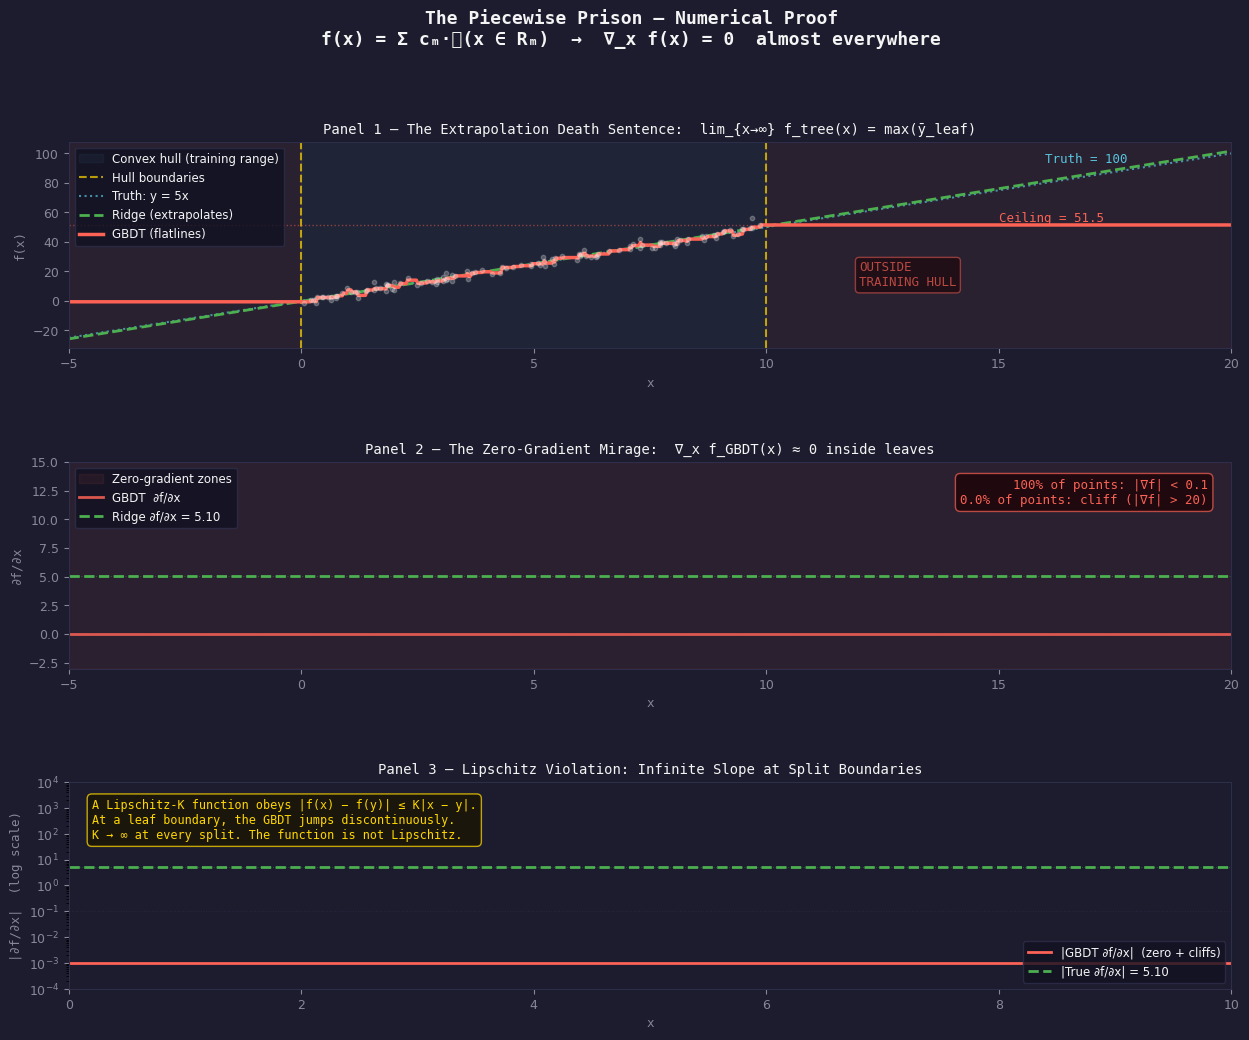


Saved: piecewise_prison_proof.png

Conclusion:
  GBDT: 100% zero-gradient, 0.0% cliffs, 49 units of extrapolation error at x=20
  Ridge: constant slope, 1.58 extrapolation error at x=20

The GBDT fits the training data.
The GBDT has no concept of the structure that generated it.
These are different things.
The confusion matrix measures the first.
Production failures expose the second.


In [1]:


# !pip install xgboost scikit-learn -q

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

 ──────────────────────────────────────
BG    = '#1C1C2E'
BLUE  = '#58C4DD'
GOLD  = '#FFD700'
RED   = '#FC6255'
GREEN = '#4CAF50'
WHITE = '#F4F4F4'
DIM   = '#888899'
GRID  = '#2E2E4A'

def style_ax(ax, title='', xlabel='', ylabel=''):
    ax.set_facecolor(BG)
    ax.tick_params(colors=DIM, labelsize=9)
    for spine in ax.spines.values():
        spine.set_color(GRID)
    if xlabel: ax.set_xlabel(xlabel, color=DIM, fontfamily='monospace', fontsize=9)
    if ylabel: ax.set_ylabel(ylabel, color=DIM, fontfamily='monospace', fontsize=9)
    if title:  ax.set_title(title, color=WHITE, fontfamily='monospace', fontsize=10)


# ════════════════════════════════════════════════════════════
# EXPERIMENT 1 — THE EXTRAPOLATION DEATH SENTENCE
# Universe: y = 5x  (linear, the simplest possible structure)
# Train on x ∈ [0, 10]. Test on x ∈ [-5, 20].
# The GBDT never leaves the training range.
# ════════════════════════════════════════════════════════════

N_TRAIN  = 120
X_train  = np.sort(np.random.uniform(0, 10, N_TRAIN)).reshape(-1, 1)
y_train  = 5 * X_train.flatten() + np.random.normal(0, 2, N_TRAIN)

X_test   = np.linspace(-5, 20, 800).reshape(-1, 1)
y_truth  = 5 * X_test.flatten()

gbdt1  = XGBRegressor(n_estimators=120, max_depth=4, learning_rate=0.08)
gbdt1.fit(X_train, y_train)
ridge1 = Ridge(alpha=0.1)
ridge1.fit(X_train, y_train)

y_gbdt1  = gbdt1.predict(X_test)
y_ridge1 = ridge1.predict(X_test)


# ════════════════════════════════════════════════════════════
# EXPERIMENT 2 — THE ZERO-GRADIENT MIRAGE
# Numerically compute ∂f/∂x for both models at every test point.
# Truth: constant slope = 5.0 everywhere.
# GBDT: zero inside each leaf, undefined at boundaries.
#
# Also: compute the Lipschitz constant violation at each split.
# A function is Lipschitz-K if |f(x) - f(y)| ≤ K|x - y|.
# At a leaf boundary, the GBDT jumps discontinuously.
# Lipschitz constant at that point → ∞.
# ════════════════════════════════════════════════════════════

EPS = 1e-6
grad_gbdt  = (gbdt1.predict(X_test + EPS) - gbdt1.predict(X_test - EPS)) / (2 * EPS)
grad_ridge = np.full(len(X_test), ridge1.coef_[0])

# Lipschitz violation: find points where |gradient| >> true slope
lipschitz_violations = np.abs(grad_gbdt) > 3 * abs(ridge1.coef_[0])
pct_zero  = (np.abs(grad_gbdt) < 0.1).mean()
pct_cliff = (np.abs(grad_gbdt) > 20).mean()

print("=" * 60)
print("EXPERIMENT 1 & 2: UNIVARIATE PROOF")
print("=" * 60)
print(f"True slope:                         {5.0:.3f}")
print(f"Ridge recovered slope:              {ridge1.coef_[0]:.3f}")
print(f"GBDT mean gradient (test range):    {grad_gbdt.mean():.3f}")
print(f"GBDT gradient std:                  {grad_gbdt.std():.3f}")
print()
print(f"% test points with |∇f| < 0.1:     {pct_zero*100:.1f}%  (zero-gradient zone)")
print(f"% test points with |∇f| > 20:      {pct_cliff*100:.1f}%  (cliff/discontinuity)")
print()

# Extrapolation error
gbdt_at_20  = gbdt1.predict([[20]])[0]
true_at_20  = 5 * 20
ridge_at_20 = ridge1.predict([[20]])[0]
print(f"At x=20 (outside hull):             true={true_at_20:.1f}")
print(f"  GBDT:   {gbdt_at_20:.1f}  (error: {abs(gbdt_at_20 - true_at_20):.1f})")
print(f"  Ridge:  {ridge_at_20:.1f}  (error: {abs(ridge_at_20 - true_at_20):.1f})")


# ════════════════════════════════════════════════════════════
# EXPERIMENT 3 — CURSE OF DIMENSIONALITY ON AXIS-ALIGNED SPLITS
# In d dimensions, to approximate a diagonal hyperplane
# y = Σᵢ xᵢ with axis-aligned partitions to precision ε,
# you need at least (1/ε)^d leaf nodes.
# This grows exponentially. The manifold does not.
# ════════════════════════════════════════════════════════════

print()
print("=" * 60)
print("EXPERIMENT 3: CURSE OF DIMENSIONALITY")
print("To approximate y = Σᵢ xᵢ to ε=0.1 precision")
print("with axis-aligned splits:")
print("=" * 60)

eps_target = 0.1
dims       = [1, 2, 3, 5, 8, 10, 20]
for d in dims:
    leaves_needed = int((1 / eps_target) ** d)
    print(f"  d={d:2d} dimensions: {leaves_needed:>20,} leaf nodes required")

print()
print("A linear model: d+1 parameters. Always.")
print("The grid scales as (1/ε)^d. The manifold does not.")


# ════════════════════════════════════════════════════════════
# FIGURE: THREE-PANEL PROOF
# Panel 1: The Plateau (extrapolation death)
# Panel 2: The Vanishing Jacobian (zero gradient)
# Panel 3: Lipschitz constant — cliffs at split boundaries
# ════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(15, 11), facecolor=BG)
fig.suptitle(
    "The Piecewise Prison — Numerical Proof\n"
    "f(x) = Σ cₘ·𝟙(x ∈ Rₘ)  →  ∇_x f(x) = 0  almost everywhere",
    color=WHITE, fontsize=13, fontfamily='monospace', fontweight='bold', y=1.00
)
gs = GridSpec(3, 1, figure=fig, hspace=0.55)

# ── Panel 1: The Plateau ─────────────────────────────────────
ax1 = fig.add_subplot(gs[0])
style_ax(ax1,
    title="Panel 1 — The Extrapolation Death Sentence:  lim_{x→∞} f_tree(x) = max(ȳ_leaf)",
    xlabel="x",
    ylabel="f(x)")

ax1.axvspan(-5, 0,  color=RED,  alpha=0.06)
ax1.axvspan(10, 20, color=RED,  alpha=0.06)
ax1.axvspan(0,  10, color=BLUE, alpha=0.05, label='Convex hull (training range)')
ax1.axvline(0,  color=GOLD, lw=1.5, ls='--', alpha=0.7)
ax1.axvline(10, color=GOLD, lw=1.5, ls='--', alpha=0.7, label='Hull boundaries')

ax1.scatter(X_train, y_train, color=WHITE, alpha=0.25, s=10, zorder=5)
ax1.plot(X_test, y_truth,  color=BLUE,  lw=1.5, ls=':', alpha=0.7, label='Truth: y = 5x')
ax1.plot(X_test, y_ridge1, color=GREEN, lw=2.0, ls='--', label='Ridge (extrapolates)')
ax1.plot(X_test, y_gbdt1,  color=RED,   lw=2.5, label='GBDT (flatlines)')

flatline_val = np.mean(y_gbdt1[X_test.flatten() > 12])
ax1.axhline(flatline_val, color=RED, lw=1.0, ls=':', alpha=0.5)
ax1.text(15, flatline_val + 2,
    f'Ceiling = {flatline_val:.1f}',
    color=RED, fontsize=9, fontfamily='monospace')
ax1.text(16, true_at_20 - 6,
    f'Truth = {true_at_20}',
    color=BLUE, fontsize=9, fontfamily='monospace')

ax1.text(12, 10, 'OUTSIDE\nTRAINING HULL',
    color=RED, fontsize=9, fontfamily='monospace', alpha=0.7,
    bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.5, boxstyle='round,pad=0.3'))

ax1.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE,
           fontsize=8.5, loc='upper left')
ax1.set_xlim(-5, 20)

# ── Panel 2: Vanishing Jacobian ──────────────────────────────
ax2 = fig.add_subplot(gs[1])
style_ax(ax2,
    title="Panel 2 — The Zero-Gradient Mirage:  ∇_x f_GBDT(x) ≈ 0 inside leaves",
    xlabel="x",
    ylabel="∂f/∂x")

ax2.axhline(0, color=GRID, lw=0.8, ls=':')
ax2.axhline(ridge1.coef_[0], color=GREEN, lw=0.8, ls=':', alpha=0.4)

# shade zero-gradient regions
zero_mask = np.abs(grad_gbdt) < 0.5
ax2.fill_between(X_test.flatten(), -3, 15,
    where=zero_mask, color=RED, alpha=0.07, label='Zero-gradient zones')

ax2.plot(X_test, grad_gbdt,  color=RED,   lw=2.0, alpha=0.85, label='GBDT  ∂f/∂x')
ax2.plot(X_test, grad_ridge, color=GREEN, lw=2.0, ls='--',     label=f'Ridge ∂f/∂x = {ridge1.coef_[0]:.2f}')

ax2.set_ylim(-3, 15)
ax2.set_xlim(-5, 20)

ax2.text(0.98, 0.92,
    f'{pct_zero*100:.0f}% of points: |∇f| < 0.1\n{pct_cliff*100:.1f}% of points: cliff (|∇f| > 20)',
    transform=ax2.transAxes, ha='right', va='top',
    color=RED, fontsize=9, fontfamily='monospace',
    bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.7, boxstyle='round,pad=0.4'))

ax2.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE,
           fontsize=8.5, loc='upper left')

# ── Panel 3: Lipschitz Constant ──────────────────────────────
ax3 = fig.add_subplot(gs[2])
style_ax(ax3,
    title="Panel 3 — Lipschitz Violation: Infinite Slope at Split Boundaries",
    xlabel="x",
    ylabel="|∂f/∂x|  (log scale)")

# Only show test range inside training hull for clarity
inside_mask = (X_test.flatten() >= 0) & (X_test.flatten() <= 10)
x_in   = X_test.flatten()[inside_mask]
g_in   = np.abs(grad_gbdt[inside_mask])
g_true = np.abs(grad_ridge[inside_mask])

ax3.semilogy(x_in, g_in + 1e-3, color=RED,   lw=2.0, label='|GBDT ∂f/∂x|  (zero + cliffs)')
ax3.semilogy(x_in, g_true,      color=GREEN, lw=2.0, ls='--', label=f'|True ∂f/∂x| = {abs(ridge1.coef_[0]):.2f}')
ax3.axhline(0.1,  color=GRID, lw=0.7, ls=':', alpha=0.6)
ax3.axhline(ridge1.coef_[0], color=GREEN, lw=0.7, ls=':', alpha=0.4)

ax3.text(0.02, 0.92,
    "A Lipschitz-K function obeys |f(x) − f(y)| ≤ K|x − y|.\n"
    "At a leaf boundary, the GBDT jumps discontinuously.\n"
    "K → ∞ at every split. The function is not Lipschitz.",
    transform=ax3.transAxes, va='top',
    color=GOLD, fontsize=8.5, fontfamily='monospace',
    bbox=dict(facecolor='#1a1400', edgecolor=GOLD, alpha=0.75, boxstyle='round,pad=0.4'))

ax3.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE,
           fontsize=8.5, loc='lower right')
ax3.set_xlim(0, 10)
ax3.set_ylim(1e-4, 1e4)

plt.savefig('piecewise_prison_proof.png', dpi=130, bbox_inches='tight', facecolor=BG)
plt.show()
print("\nSaved: piecewise_prison_proof.png")
print("\nConclusion:")
print(f"  GBDT: {pct_zero*100:.0f}% zero-gradient, {pct_cliff*100:.1f}% cliffs, "
      f"{abs(gbdt_at_20 - true_at_20):.0f} units of extrapolation error at x=20")
print(f"  Ridge: constant slope, {abs(ridge_at_20 - true_at_20):.2f} extrapolation error at x=20")
print()
print("The GBDT fits the training data.")
print("The GBDT has no concept of the structure that generated it.")
print("These are different things.")
print("The confusion matrix measures the first.")
print("Production failures expose the second.")